# Neural Dynamics

## 1. 

### Nernst's eq:

\begin{align*}
\Delta V &= \frac{kT}{ne^-}\ln{\frac{I_{out}}{I_{in}}} \\
\end{align*}
\begin{align*}
\Bigg\{ k  &= 8.6x10^{-5}\frac{e^-V}{ºK}  &  T  &= 293.15ºK  &  n  &= 1 \Bigg\}
\end{align*}

### Data:

|ION|I_in|I_out|
|-|-|-|
|k<sup>+</sup>|430|20|
|Na<sup>+</sup>|50|440|
|Cl<sup>-</sup>|65|550|

### So:
\begin{align}
\Delta V_{k} & = -77mV \\
\Delta V_{Na} & = +54,8mV \\
\Delta V_{Cl} & = -53.8mV \\
\end{align}

## 2.

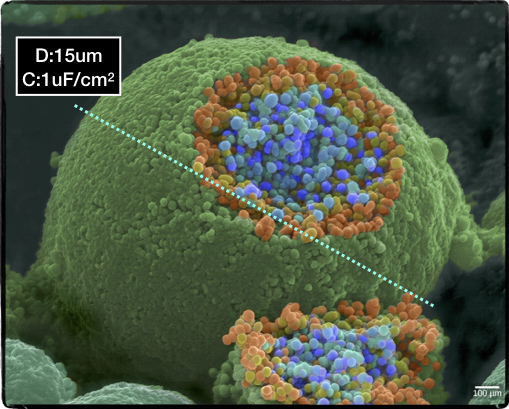


\begin{align*}
C \Delta V &= \Delta Q  &  Area &= 4 \pi r^2  &  Volumen &= \frac{4}{3} \pi r^3  &  \Delta V &= 100 mV \\  
\end{align*}

\begin{align*}
Na^+Iones &= 1.8x10^7\\
Na^+Molar &= 0.2 \mu M\\
\end{align*}


## 3.



### Import Modules

In [21]:
# by F. Rodriguez
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import RK23
plt.style.use('seaborn-darkgrid')

### Definitions

In [22]:
# UNITS --> C : mF/cm^2   g : mS/cm^2     V : mV      i : uA/cm^2     t : msec

# TIME PARAMETERS
T = 40
max_step = 1

# INJECTED CURRENT PARAMETERS
ext_current = np.arange(0, 40, 1)

# INITIAL CONDITIONS
init = [-65, 0.05, 0.95, 0.05]  # [V, m, h, n]

# CONSTANTS
C = 1.0;
g_Na = 120.0;   g_K = 36.0;     g_l = 0.3
V_Na = 50.0;    V_K = -77.0;    V_l = -54.387

### Complementary functions

In [23]:
# VOLTAGE GATED CHANNELS KINETIC
def alpha_m(V): return 0.1*(V+40.0)/(1.0 - np.exp(-(V+40.0) / 10.0))
def beta_m(V) : return 4.0*np.exp(-(V+65.0) / 18.0)
def m_inf(V)  : return alpha_m(V) / (alpha_m(V)+beta_m(V))
def alpha_h(V): return 0.07*np.exp(-(V+65.0) / 20.0)
def beta_h(V) : return 1.0/(1.0 + np.exp(-(V+35.0) / 10.0))
def h_inf(V)  : return alpha_h(V) / (alpha_h(V)-beta_h(V))
def alpha_n(V): return 0.01*(V+55.0)/(1.0 - np.exp(-(V+55.0) / 10.0))
def beta_n(V) : return 0.125*np.exp(-(V+65) / 80.0)
def n_inf(V)  : return alpha_n(V) / (alpha_n(V)-beta_n(V))

# MEMBRANE CURRENT
def I_Na(V,m,h): return g_Na * m**3 * h * (V - V_Na)  # Soldium
def I_K(V, n)  : return g_K * n**4 * (V - V_K)  # Potassium
def I_l(V)     : return g_l * (V - V_l)  #Leak


### Equations

In [24]:
# ORDINARY DIFFERENTIAL EQUATIONS
def ode4(t, y):
    '''Full Hogdkin-Huxley'''
    V, m, h, n = y
    dVdt = (I_inj(t) - I_Na(V, m, h) - I_K(V, n) - I_l(V)) / C
    dmdt = alpha_m(V)*(1.0-m) - beta_m(V)*m
    dhdt = alpha_h(V)*(1.0-h) - beta_h(V)*h
    dndt = alpha_n(V)*(1.0-n) - beta_n(V)*n
    return dVdt, dmdt, dhdt, dndt

def ode3(t, y):
    '''m_inf(V) = m(t)'''
    V, h, n = y
    dVdt = (I_inj(t) - I_Na(V, m_inf(V), h) - I_K(V, n) - I_l(V)) / C
    dhdt = alpha_h(V)*(1.0-h) - beta_h(V)*h
    dndt = alpha_n(V)*(1.0-n) - beta_n(V)*n
    return dVdt, dhdt, dndt

def ode2(t, y):
    '''Instant m kinetic plus n + h = cte'''
    V, n = y
    h = 0.84438 - n
    dVdt = (I_inj(t) - I_Na(V, m_inf(V), h) - I_K(V, n) - I_l(V)) / C
    dndt = alpha_n(V)*(1.0-n) - beta_n(V)*n
    return dVdt, dndt

# find frequency from voltage
def find_frequency(Voltage, time):
    peaks = np.where(np.diff(np.sign(Voltage)))[0]
    return 1.e3 / (time[peaks[-1]]-time[peaks[-3]]) if len(peaks)>3 else 0

### Solve with R-K method

In [25]:
frequency = [list() for i in range(3)]
# SOLVE HH-MODELS
for stimulus in ext_current:
    # EXTERNAL CURRENT
    def I_inj(t): return stimulus

    # INTEGRATION METHOD
    X = [   RK23(ode4, t0=0.00, y0=init, t_bound=T, max_step=max_step),
            RK23(ode3, t0=0.00, y0=[-65, 0.95, 0.05], t_bound=T, max_step=max_step),
            RK23(ode2, t0=0.00, y0=[-65, 0.05], t_bound=T, max_step=max_step)
            ]

    for i, x in enumerate(X):
        # restart variables
        time = [0]
        output = [x.y]

        # Solve full HH-model
        while x.status=='running':
            x.step()
            time.append(x.t)
            output.append(x.y)
        output = np.array(output)

        # Frecuency for this imput current
        frequency[i].append(find_frequency(output[:,0], time))


### Plot

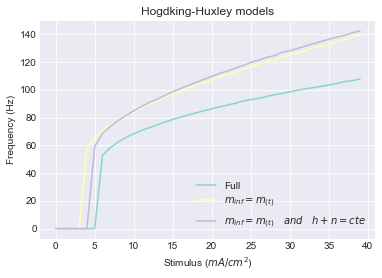

In [29]:
plt.title('Hogdking-Huxley models')
plt.plot(ext_current, frequency[0], label='Full')
plt.plot(ext_current, frequency[1], label='$m_{inf}=m_{(t)}$')
plt.plot(ext_current, frequency[2], label='$m_{inf}=m_{(t)} \quad and \quad h+n=cte$')
plt.xlabel('Stimulus ($m{A}/cm^2$)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.show()

### View

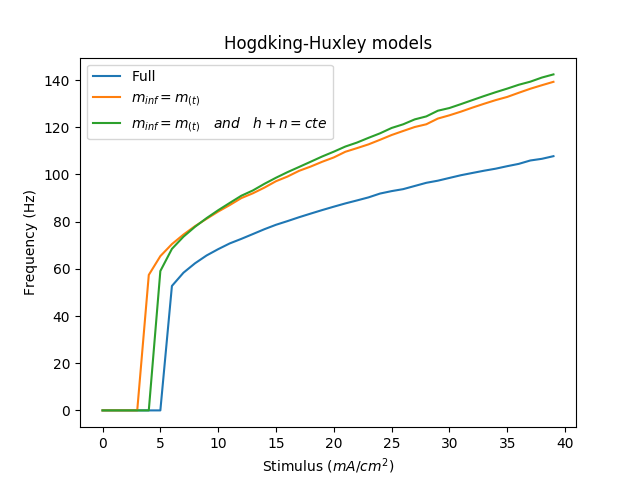

## 4.

In [30]:
# HYPERPOLARIZATION FIRING EXAMPLE
def I_inj(t): return -4*(t>40) + 4*(t>140)

# INTEGRATION METHOD
X4 = RK23(ode4, t0=0.00, y0=init, t_bound=200, max_step=max_step)

# restart variables
time = [0];   output = [X4.y]

# iterate
while X4.status=='running':
    X4.step()
    time.append(X4.t)
    output.append(X4.y)

output = np.array(output)

### Plot

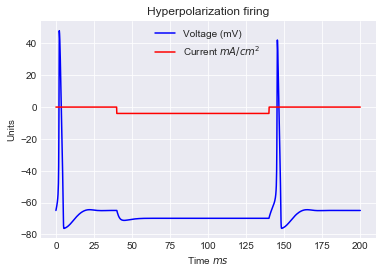

In [31]:
plt.title("Hyperpolarization firing")
plt.plot(time, output[:,0], 'b', label="Voltage (mV)")
plt.plot(time, [I_inj(i) for i in time], 'r', label='Current $m{A}/cm^2$')
plt.legend()
plt.xlabel("Time $m{s}$")
plt.ylabel("Units")
plt.show()

### Result

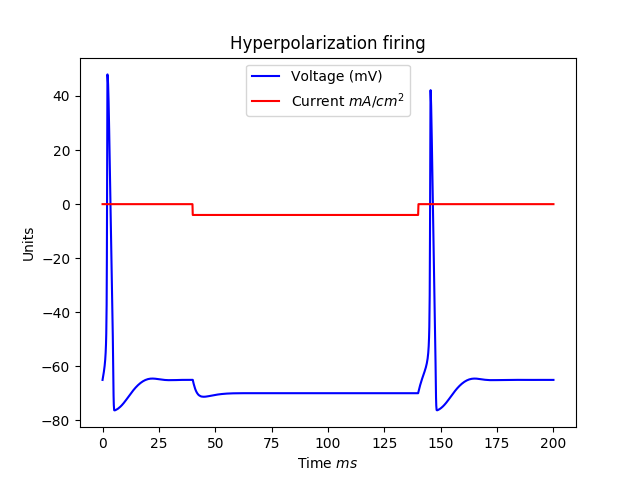